In [3]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    'cell_images/Train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    'cell_images/Test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set class weights for handling class imbalance
class_weights = {0: 1.0, 1: 3.0}  # Adjust the weight for the minority class as needed

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)

# Train the model with improved settings
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,  # Increase the number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint])


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc}')


Found 416 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


Epoch 1/30
13/13 [==============================] - 6s 396ms/step - loss: 1.1758 - accuracy: 0.5409 - val_loss: 0.5945 - val_accuracy: 0.6866
Epoch 2/30
13/13 [==============================] - 5s 356ms/step - loss: 0.8094 - accuracy: 0.6947 - val_loss: 0.5588 - val_accuracy: 0.6866
Epoch 3/30
13/13 [==============================] - 5s 375ms/step - loss: 0.5992 - accuracy: 0.8149 - val_loss: 0.4892 - val_accuracy: 0.7687
Epoch 4/30
13/13 [==============================] - 10s 773ms/step - loss: 0.4583 - accuracy: 0.8534 - val_loss: 0.4637 - val_accuracy: 0.7910
Epoch 5/30
13/13 [==============================] - 4s 312ms/step - loss: 0.4426 - accuracy: 0.8726 - val_loss: 0.4391 - val_accuracy: 0.8134
Epoch 6/30
13/13 [==============================] - 9s 716ms/step - loss: 0.4039 - accuracy: 0.8822 - val_loss: 0.3961 - val_accuracy: 0.8433
Epoch 7/30
13/13 [==============================] - 4s 310ms/step - loss: 0.3598 - accuracy: 0.8918 - val_loss: 0.3689 - val_accuracy: 0.8582
Epoch

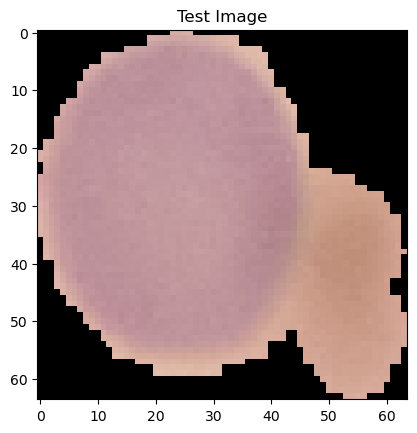

1/1 [==============================] - 0s 41ms/step
Prediction: Uninfected


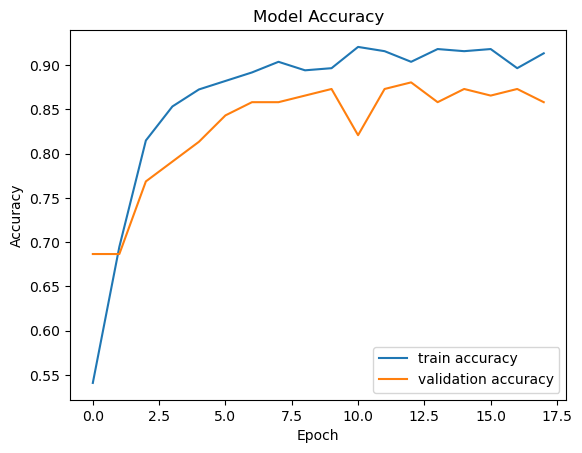

In [19]:
import tensorflow as tf
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the best model
model.load_weights('best_model.h5')

# Load and preprocess the test image
test_image = image.load_img("cell_images/Test/Uninfected/2.png", target_size=(64, 64))
plt.imshow(test_image)
plt.title("Test Image")
plt.show()
test_image = image.img_to_array(test_image)
test_image = test_image / 255.0  # Normalize the image (same as training data preprocessing)
test_image = tf.expand_dims(test_image, axis=0)  # Add a batch dimension

# Make a prediction using the loaded model
result = model.predict(test_image)

# Interpret the prediction
if result[0][0] <0.5:
    prediction = 'Infected'
else:
    prediction = 'Uninfected'

print(f'Prediction: {prediction}')

# Plot the accuracy of the model
plt.figure()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('AccVal_acc')
plt.show()



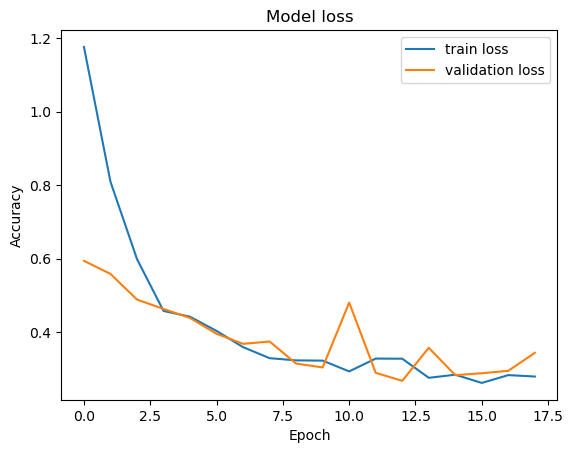

In [20]:
# Plot the loss of the model
plt.figure()
plt.title('Model loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('LossVal_loss')
plt.show()

1/1 [==============================] - 0s 39ms/step
File: 2.png, Prediction: Infected
File: 4.png, Prediction: Infected
File: C39P4thinF_original_IMG_20150622_105554_cell_12.png, Prediction: Infected
File: C39P4thinF_original_IMG_20150622_105554_cell_13.png, Prediction: Infected
File: C39P4thinF_original_IMG_20150622_105803_cell_84.png, Prediction: Infected
File: C39P4thinF_original_IMG_20150622_105803_cell_90.png, Prediction: Infected
File: C3thin_original_IMG_20150608_162922_cell_145.png, Prediction: Uninfected
File: C3thin_original_IMG_20150608_162922_cell_191.png, Prediction: Uninfected
File: C3thin_original_IMG_20150608_162922_cell_205.png, Prediction: Uninfected
File: C3thin_original_IMG_20150608_162922_cell_217.png, Prediction: Uninfected


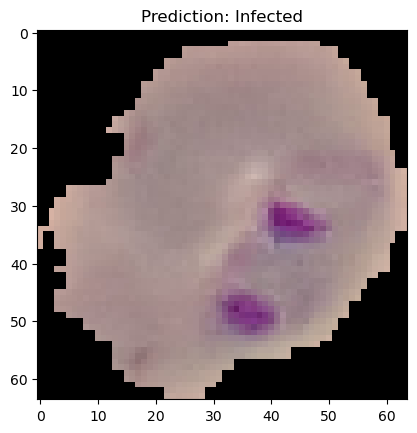

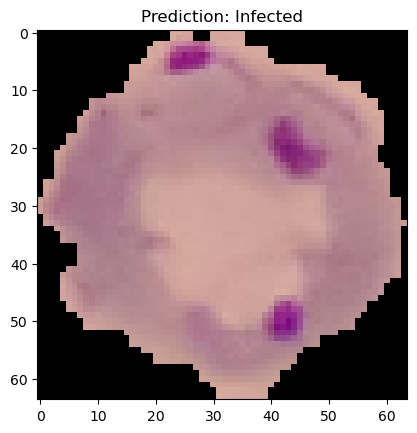

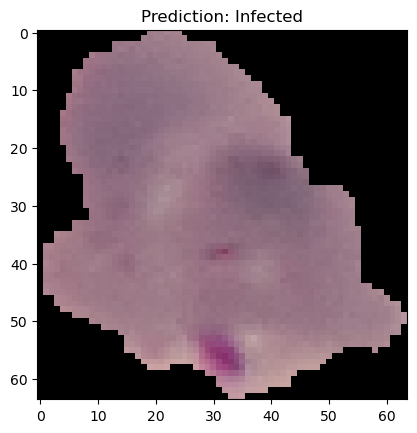

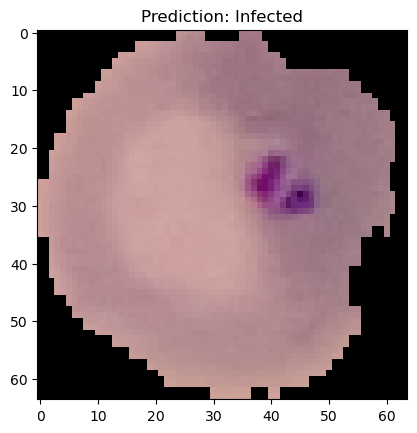

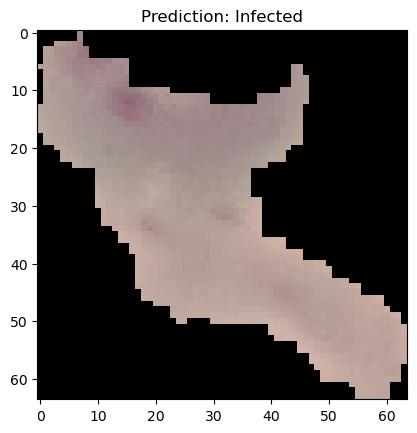

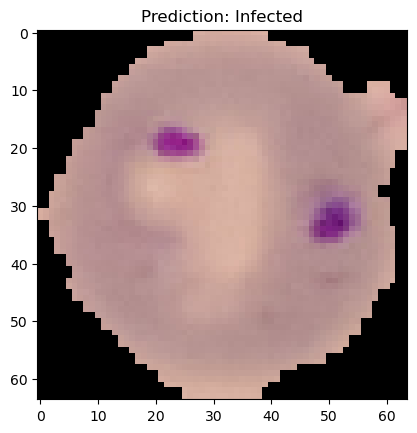

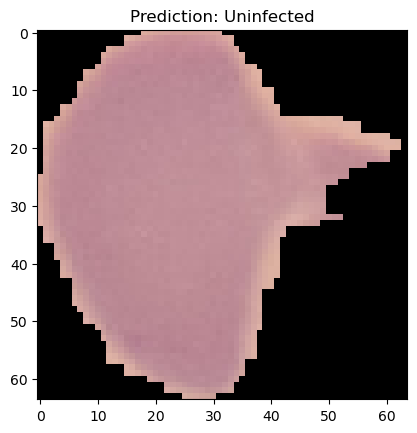

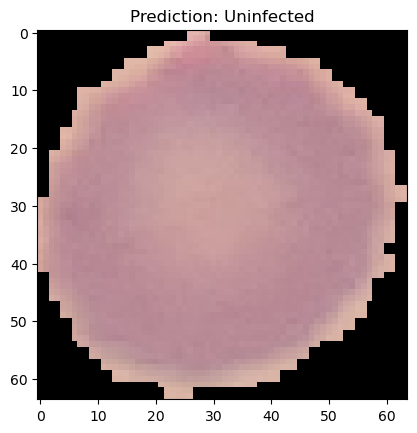

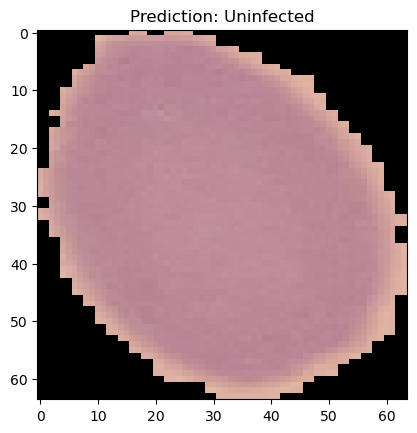

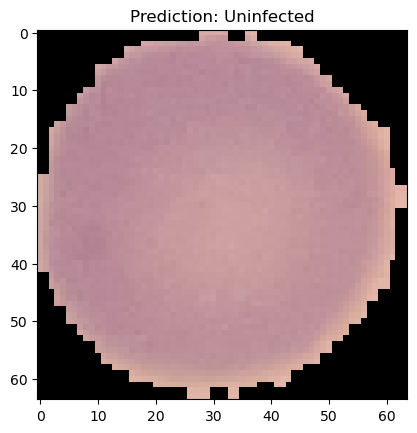

In [22]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the best model
model.load_weights('best_model.h5')

# Specify the directory containing multiple test images
test_image_dir = 'Prediction_images' 

# List all image files in the directory
test_image_files = os.listdir(test_image_dir)

# Create lists to store predictions and file names
predictions = []
file_names = []

# Iterate through the test image files
for image_file in test_image_files:
    # Load and preprocess each test image
    test_image_path = os.path.join(test_image_dir, image_file)
    test_image = image.load_img(test_image_path, target_size=(64, 64))
    test_image = image.img_to_array(test_image)
    test_image = test_image / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    # Make a prediction using the loaded model
    result = model.predict(test_image)

    # Interpret the prediction
    if result[0][0] < 0.5:
        prediction = 'Infected'
    else:
        prediction = 'Uninfected'

    # Append the prediction and file name to the respective lists
    predictions.append(prediction)
    file_names.append(image_file)

# Print predictions for all images
for file_name, prediction in zip(file_names, predictions):
    print(f'File: {file_name}, Prediction: {prediction}')

# Optionally, you can also visualize the images and their predictions
for file_name, prediction in zip(file_names, predictions):
    test_image_path = os.path.join(test_image_dir, file_name)
    test_image = image.load_img(test_image_path, target_size=(64, 64))
    plt.imshow(test_image)
    plt.title(f'Prediction: {prediction}')
    plt.show()
